# Night2Day Dataset Visualization

This notebook demonstrates how to load and visualize images from the night2day train dataset using the environment we created with PyTorch, torchvision, Pillow, NumPy, and Matplotlib.

## 1. Import Required Libraries

Import the necessary libraries for image loading, processing, and visualization.

In [1]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

Libraries imported successfully!
PyTorch version: 2.4.1+cu121
Torchvision version: 0.19.1+cu121


## 2. Load Image Dataset

Set up the path to the night2day train dataset and define transforms for image loading.

In [2]:
# Set up the path to the night2day train dataset
dataset_path = Path("../../data/night2day/train")

# Check if the path exists
if dataset_path.exists():
    print(f"Dataset path found: {dataset_path.absolute()}")
    
    # List subdirectories (classes) in the train folder
    classes = [d.name for d in dataset_path.iterdir() if d.is_dir()]
    print(f"Classes found: {classes}")
    
    # Count total images
    total_images = len(list(dataset_path.rglob("*.jpg")))
    print(f"Total images in train set: {total_images}")
else:
    print(f"Dataset path not found: {dataset_path.absolute()}")

# Define transforms for loading images (no resizing since we need to split first)
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert PIL Image to tensor
])

print("Transforms defined successfully!")
print("Note: Images are coupled (concatenated) and will be split into pairs during loading.")

Dataset path found: /NAS/PROJECTS/BOMRGD/phd_fouad/multimodal_encoder_guidance/src/data_manip/../../data/night2day/train
Classes found: []
Total images in train set: 17823
Transforms defined successfully!
Note: Images are coupled (concatenated) and will be split into pairs during loading.


## 3. Split and Display Sample Image Pairs

Load coupled images from the dataset, split them into individual images, and prepare them for visualization. Each image file contains two 256x256 images concatenated together.

In [3]:
# Load sample images from the dataset and split coupled images
def load_sample_images(dataset_path, num_samples=4):
    """Load a sample of coupled images from the dataset and split them into pairs"""
    image_paths = list(dataset_path.rglob("*.jpg"))
    
    if len(image_paths) == 0:
        print("No images found in the dataset!")
        return [], [], []
    
    # Select random sample of images
    import random
    random.seed(42)  # For reproducible results
    sample_paths = random.sample(image_paths, min(num_samples, len(image_paths)))
    
    image_pairs_a = []
    image_pairs_b = []
    image_names = []
    
    for img_path in sample_paths:
        try:
            # Load image using PIL
            img = Image.open(img_path).convert('RGB')
            
            # Get image dimensions
            width, height = img.size
            print(f"Original image size: {width}x{height}")
            
            # Split the coupled image into two halves
            # Assuming images are concatenated horizontally (side by side)
            if width == 512 and height == 256:
                # Split horizontally: left half and right half
                img_a = img.crop((0, 0, 256, 256))          # Left half (first image)
                img_b = img.crop((256, 0, 512, 256))        # Right half (second image)
            elif width == 256 and height == 512:
                # Split vertically: top half and bottom half
                img_a = img.crop((0, 0, 256, 256))          # Top half (first image)
                img_b = img.crop((0, 256, 256, 512))        # Bottom half (second image)
            else:
                print(f"Unexpected image size {width}x{height} for {img_path.name}")
                continue
            
            # Apply transforms to both images
            img_a_tensor = transform(img_a)
            img_b_tensor = transform(img_b)
            
            # Convert back to numpy for matplotlib
            img_a_np = img_a_tensor.permute(1, 2, 0).numpy()
            img_b_np = img_b_tensor.permute(1, 2, 0).numpy()
            
            image_pairs_a.append(img_a_np)
            image_pairs_b.append(img_b_np)
            image_names.append(img_path.name)
            
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    
    return image_pairs_a, image_pairs_b, image_names

# Load sample images
sample_images_a, sample_images_b, sample_names = load_sample_images(dataset_path, num_samples=4)
print(f"Loaded {len(sample_images_a)} image pairs")

Original image size: 512x256
Original image size: 512x256
Original image size: 512x256
Original image size: 512x256
Loaded 4 image pairs


## 4. Plot Image Pairs Using Matplotlib

Display the split image pairs in a grid layout using matplotlib. Each row shows a pair of images (A and B) that were originally concatenated in a single file.

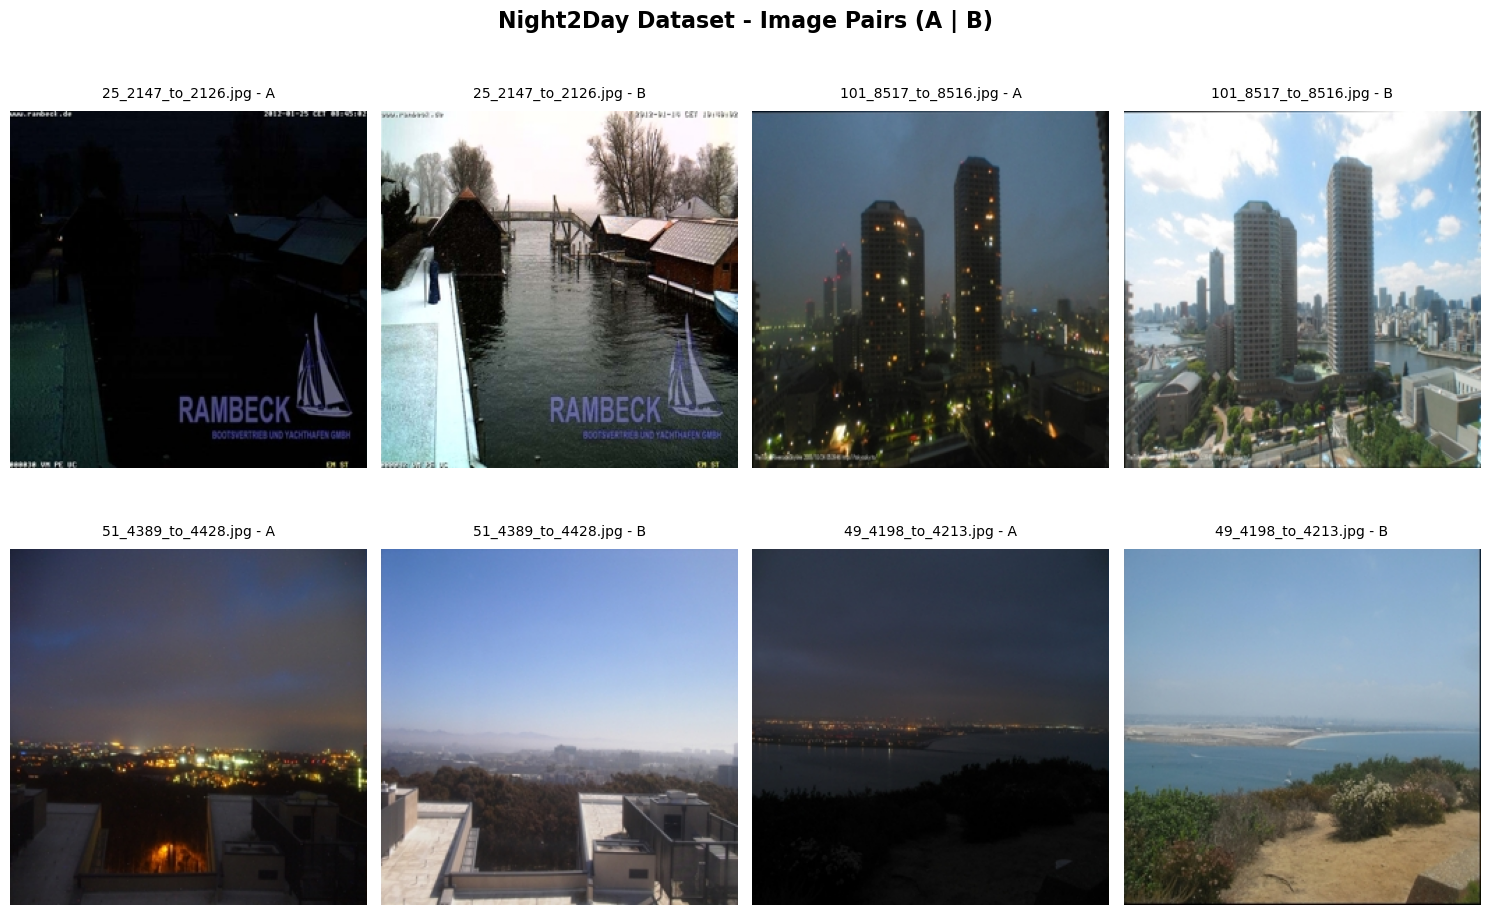

In [4]:
# Plot image pairs in a grid using matplotlib
def plot_image_pairs(images_a, images_b, names, rows=2, cols=2, figsize=(15, 10)):
    """Plot image pairs in a grid layout showing A and B side by side"""
    fig, axes = plt.subplots(rows, cols * 2, figsize=figsize)  # cols * 2 for pairs
    fig.suptitle('Night2Day Dataset - Image Pairs (A | B)', fontsize=16, fontweight='bold')
    
    # Flatten axes array for easier indexing
    axes = axes.flatten()
    
    pair_idx = 0
    for i in range(0, len(axes), 2):  # Step by 2 since we're showing pairs
        if pair_idx < len(images_a):
            # Display first image of the pair (A)
            axes[i].imshow(images_a[pair_idx])
            axes[i].set_title(f"{names[pair_idx]} - A", fontsize=10, pad=10)
            axes[i].axis('off')
            
            # Display second image of the pair (B)
            if i + 1 < len(axes):
                axes[i + 1].imshow(images_b[pair_idx])
                axes[i + 1].set_title(f"{names[pair_idx]} - B", fontsize=10, pad=10)
                axes[i + 1].axis('off')
            
            pair_idx += 1
        else:
            # Hide empty subplots
            axes[i].axis('off')
            if i + 1 < len(axes):
                axes[i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display the sample image pairs
if sample_images_a and sample_images_b:
    plot_image_pairs(sample_images_a, sample_images_b, sample_names)
else:
    print("No image pairs to display. Please check the dataset path.")

## 5. Custom DataLoader for Contrastive Learning

Now let's test our custom dataloader that supports both regular mode (joint pairs only) and contrastive mode (mixed joint/independent pairs with labels).

In [8]:
# Import our custom dataset
import sys
sys.path.append('../')  # Add current directory to path
from datasets.night2day_dataset import Night2DayDataset, create_dataloaders

# Create dataloaders for both modes
print("=== Creating DataLoaders ===")

# Regular mode (joint pairs only)
dataloaders_regular = create_dataloaders(
    train_path="../../data/night2day/train",
    resolution=64,
    contrastive=False,
    batch_size=8,
    num_workers=0  # Set to 0 for notebook compatibility
)

# Contrastive mode (mixed joint/independent pairs with labels)
dataloaders_contrastive = create_dataloaders(
    train_path="../../data/night2day/train",
    resolution=64,
    contrastive=True,
    batch_size=8,
    num_workers=0,  # Set to 0 for notebook compatibility
    split_ratio=0.5  # 50% joint, 50% independent
)

print("DataLoaders created successfully!")

=== Creating DataLoaders ===
Loaded 17823 images from ../../data/night2day/train
Resolution: 64x64
Contrastive mode: False
Loaded 17823 images from ../../data/night2day/train
Resolution: 64x64
Contrastive mode: True
Joint/Independent split ratio: 0.5
DataLoaders created successfully!


In [9]:
# Function to visualize dataloader samples
def visualize_dataloader_samples(dataloader, title, num_samples=4, contrastive=False):
    """Visualize samples from a dataloader"""
    
    # Get a batch
    batch = next(iter(dataloader))
    
    if contrastive:
        images_a, images_b, labels = batch
        print(f"Batch shapes: A={images_a.shape}, B={images_b.shape}, Labels={labels.shape}")
        print(f"Labels: {labels.numpy()}")
    else:
        images_a, images_b = batch
        print(f"Batch shapes: A={images_a.shape}, B={images_b.shape}")
        labels = None
    
    # Convert tensors to numpy and denormalize
    def denormalize(tensor):
        # Convert from [-1, 1] to [0, 1]
        return (tensor * 0.5 + 0.5).clamp(0, 1)
    
    images_a_np = denormalize(images_a).permute(0, 2, 3, 1).numpy()
    images_b_np = denormalize(images_b).permute(0, 2, 3, 1).numpy()
    
    # Plot samples
    fig, axes = plt.subplots(2, num_samples * 2, figsize=(num_samples * 4, 8))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    for i in range(num_samples):
        # Top row: Image A
        axes[0, i*2].imshow(images_a_np[i])
        axes[0, i*2].set_title(f"Sample {i+1} - A", fontsize=10)
        axes[0, i*2].axis('off')
        
        # Top row: Image B  
        axes[0, i*2+1].imshow(images_b_np[i])
        if contrastive and labels is not None:
            label_text = "Joint" if labels[i].item() == 1.0 else "Independent"
            axes[0, i*2+1].set_title(f"Sample {i+1} - B ({label_text})", fontsize=10)
        else:
            axes[0, i*2+1].set_title(f"Sample {i+1} - B", fontsize=10)
        axes[0, i*2+1].axis('off')
    
    # Hide second row (we only need one row for pairs)
    for i in range(num_samples * 2):
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Visualization function defined!")

Visualization function defined!


### 5.1 Visualize Regular Mode (Joint Pairs Only)

=== Regular Mode Samples ===
Batch shapes: A=torch.Size([8, 3, 64, 64]), B=torch.Size([8, 3, 64, 64])


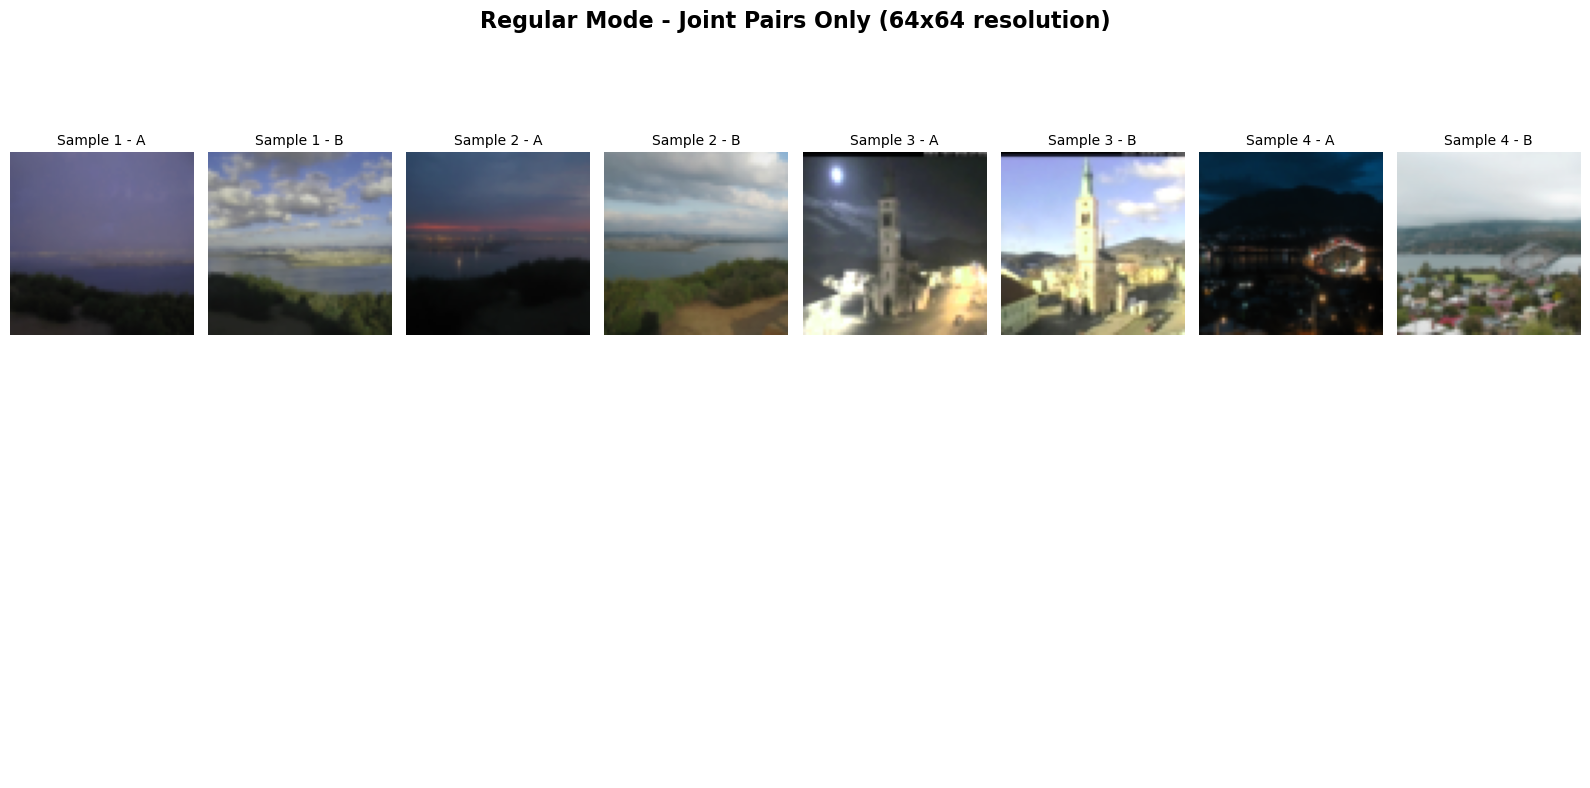

In [10]:
# Visualize regular mode (joint pairs only)
print("=== Regular Mode Samples ===")
visualize_dataloader_samples(
    dataloaders_regular['train'], 
    "Regular Mode - Joint Pairs Only (64x64 resolution)",
    num_samples=4,
    contrastive=False
)

### 5.2 Visualize Contrastive Mode (Mixed Joint/Independent Pairs)

=== Contrastive Mode Samples ===
Batch shapes: A=torch.Size([8, 3, 64, 64]), B=torch.Size([8, 3, 64, 64]), Labels=torch.Size([8])
Labels: [0. 1. 0. 1. 1. 0. 0. 1.]


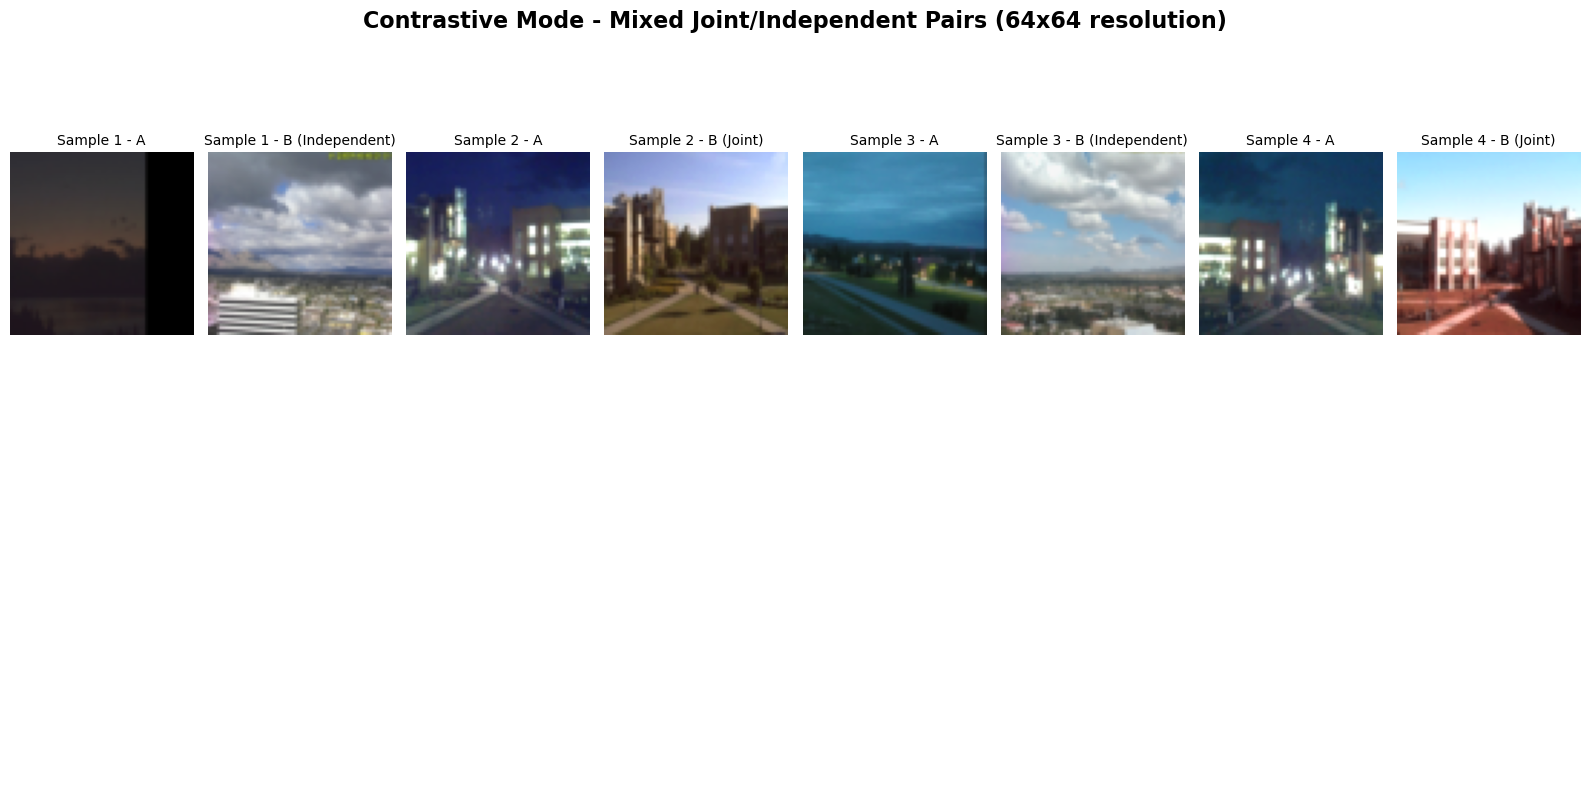

In [13]:
# Visualize contrastive mode (mixed joint/independent pairs with labels)
print("=== Contrastive Mode Samples ===")
visualize_dataloader_samples(
    dataloaders_contrastive['train'], 
    "Contrastive Mode - Mixed Joint/Independent Pairs (64x64 resolution)",
    num_samples=4,
    contrastive=True
)

### 5.3 Dataset Statistics and Usage

The custom dataloader is now ready for contrastive learning experiments!

In [ ]:
# Display dataset statistics
print("=== Dataset Statistics ===")
train_dataset_regular = dataloaders_regular['train'].dataset
train_dataset_contrastive = dataloaders_contrastive['train'].dataset

print(f"Total images in dataset: {len(train_dataset_regular)}")
print(f"Image resolution: {train_dataset_regular.resolution}x{train_dataset_regular.resolution}")
print(f"Regular mode: Returns (img_a, img_b)")
print(f"Contrastive mode: Returns (img_a, img_b, label)")
print(f"  - Label 1.0: Joint pairs (original night-day correspondence)")
print(f"  - Label 0.0: Independent pairs (shuffled, no correspondence)")
print(f"  - Split ratio: {train_dataset_contrastive.split_ratio} (joint/independent)")

print("\n=== Usage Examples ===")
print("# For regular training (e.g., GAN, autoencoder)")
print("for img_a, img_b in dataloaders_regular['train']:")
print("    # Train with paired night-day images")
print("    pass")

print("\n# For contrastive learning")
print("for img_a, img_b, label in dataloaders_contrastive['train']:")
print("    # Train contrastive model")
print("    # label=1: positive pairs, label=0: negative pairs")
print("    pass")

print("\n✅ DataLoader setup complete! Ready for contrastive learning experiments.")